In [1]:
# Add graphviz to path
import os

os.environ["PATH"] = os.environ["PATH"] + ":/opt/homebrew/bin"

# External dependency imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import logit
import seaborn as sns

# `vaxflux` imports
from vaxflux.curves import LogisticIncidenceCurve
from vaxflux.data import create_logistic_sample_dataset
from vaxflux.model import build_model

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
parameters = pd.DataFrame.from_records(
    [
        {
            "season": "2022/23",
            "strata": "All",
            "region": "National",
            "r": 0.4,
            "m": 0.6,
            "s": 14.0,
        },
        {
            "season": "2023/24",
            "strata": "All",
            "region": "National",
            "r": 0.4,
            "m": 0.55,
            "s": 14.0,
        },
    ]
)
time = np.linspace(0.0, 40.0, 25)
epsilon = 0.0012
incidence = create_logistic_sample_dataset(parameters, time, epsilon)
incidence.head()

,season,strata,region,time,incidence
0,2022/23,All,National,0.000000,0.000552
1,2022/23,All,National,1.666667,0.002788
2,2022/23,All,National,3.333333,0.006561
3,2022/23,All,National,5.000000,0.007340
4,2022/23,All,National,6.666667,0.011292


<Axes: xlabel='time', ylabel='incidence'>

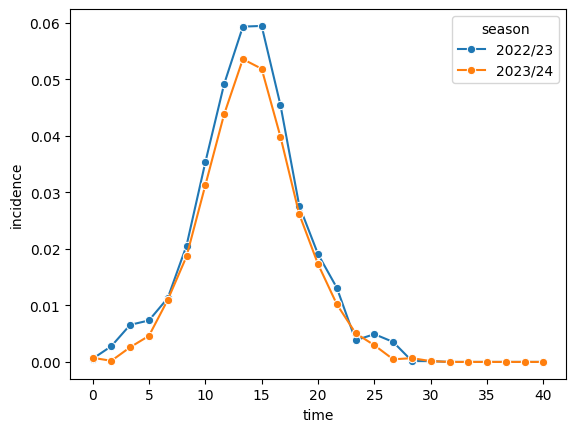

In [3]:
sns.lineplot(incidence, x="time", y="incidence", hue="season", marker="o")

<Axes: xlabel='time', ylabel='prevalence'>

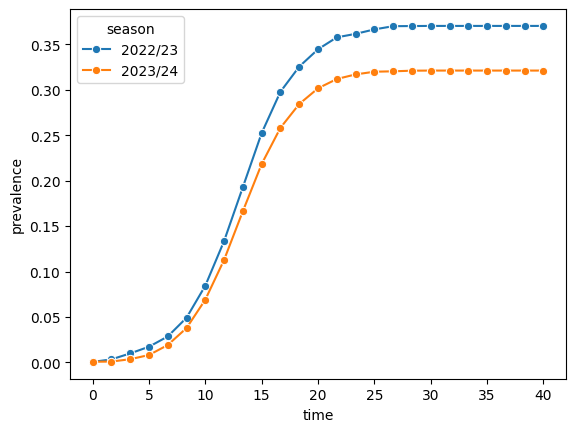

In [4]:
incidence["prevalence"] = incidence.groupby(["season", "strata", "region"])[
    "incidence"
].cumsum()
sns.lineplot(incidence, x="time", y="prevalence", hue="season", marker="o")

In [5]:
logistic_curve = LogisticIncidenceCurve()

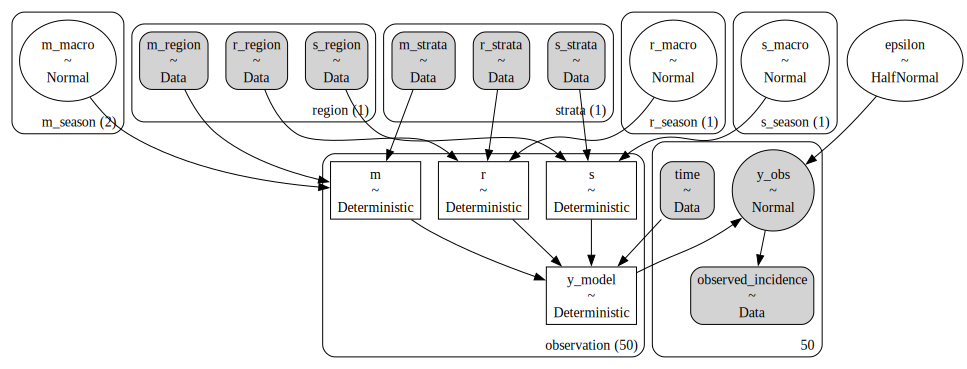

In [6]:
model = build_model(
    incidence,
    logistic_curve,
    pm.Normal,
    (pm.HalfNormal, {"sigma": 0.002}),
    {
        "m": (pm.Normal, {"mu": 1.0, "sigma": 1.0}),
        "r": (pm.Normal, {"mu": 0.5, "sigma": 0.05}),
        "s": (pm.Normal, {"mu": 10.0, "sigma": 2.0}),
    },
    season_stratified_parameters=("m"),
)

pm.model_to_graphviz(model)

In [7]:
chains = 4
samples = 1000 * chains
with model:
    trace = pm.sample(
        draws=samples, tune=samples, chains=chains, cores=2, random_seed=123
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [m_macro, r_macro, s_macro, epsilon]


Output()

Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 6 seconds.


In [8]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
epsilon,0.001,0.000,0.001,0.001,0.0,0.0,12949.0,11340.0,1.0
m[0],0.443,0.027,0.393,0.496,0.0,0.0,12758.0,12383.0,1.0
m[1],0.443,0.027,0.393,0.496,0.0,0.0,12758.0,12383.0,1.0
m[2],0.443,0.027,0.393,0.496,0.0,0.0,12758.0,12383.0,1.0
m[3],0.443,0.027,0.393,0.496,0.0,0.0,12758.0,12383.0,1.0
...,...,...,...,...,...,...,...,...,...
y_model[45],0.000,0.000,0.000,0.000,0.0,0.0,10334.0,10537.0,1.0
y_model[46],0.000,0.000,0.000,0.000,0.0,0.0,10346.0,10593.0,1.0
y_model[47],0.000,0.000,0.000,0.000,0.0,0.0,10361.0,10574.0,1.0
y_model[48],0.000,0.000,0.000,0.000,0.0,0.0,10376.0,10633.0,1.0


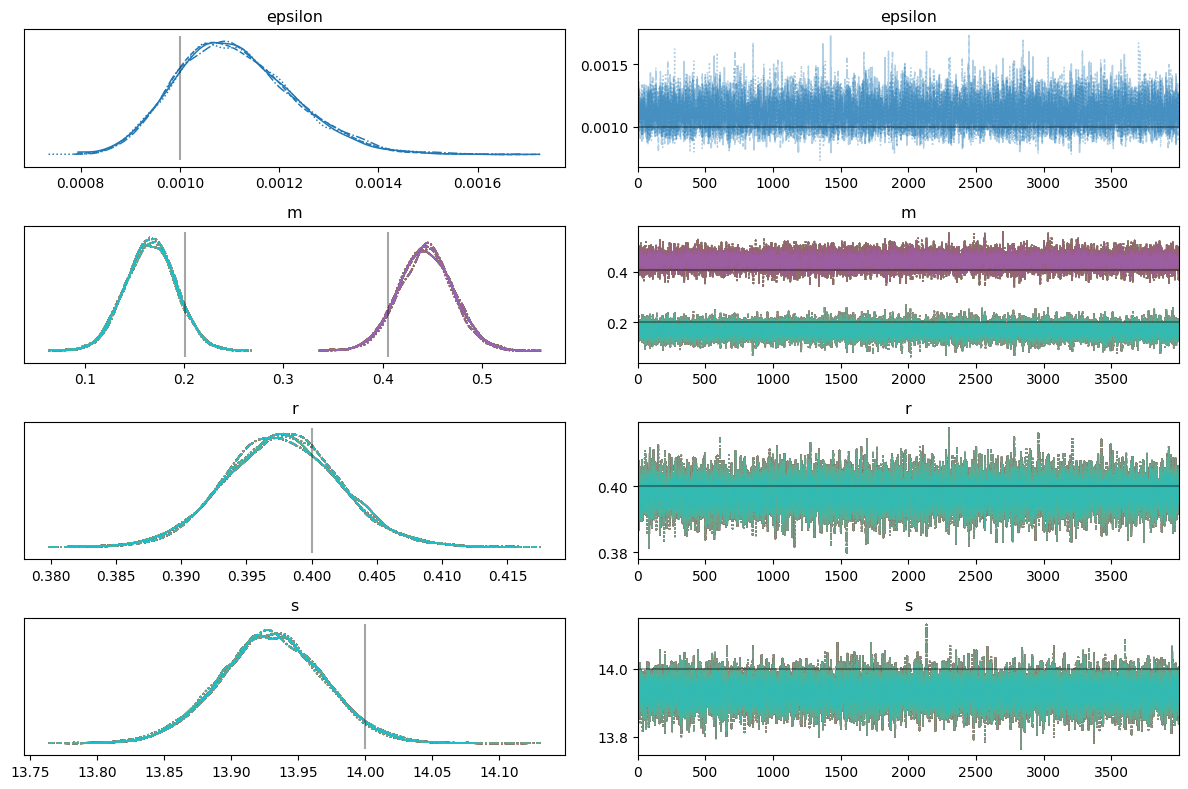

In [9]:
axes = az.plot_trace(
    trace,
    var_names=["epsilon", "m", "r", "s"],
    kind="trace",
    lines=[
        ("epsilon", {}, 0.001),
        ("m", {}, logit([0.6, 0.55])),
        ("r", {}, 0.4),
        ("s", {}, 14.0),
    ],
)
plt.tight_layout()